## Motivation

In bank operations, signature varification is an important and frequent task. If we want to automate the signature varification, the first step is to detect the signatures on a document. Once the signature is detected, we can crop them and then do the cross-checking. In this notebook, I will show how to train an object detection model using MMdetection framework to identify signatures on scanned documents.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data

#### I download the signature datasets from roboflow. Since the size of the datasets are not very large. I merged them together to form a bigger training dataset. 


In [ ]:
## https://universe.roboflow.com/object-detection/signatures-xc8up
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="L6lh8eIZGwgLDlqtrYG0")
project = rf.workspace("roboflow-100").project("signatures-xc8up")
dataset = project.version(2).download("coco")

In [ ]:
## https://universe.roboflow.com/trainsignature/tobacco800-signatures
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="L6lh8eIZGwgLDlqtrYG0")
project = rf.workspace("trainsignature").project("tobacco800-signatures")
dataset = project.version(2).download("coco")

In [ ]:
## Combine the above dataset together so that we will have more data to train
## Need to make sure the two datasets have the same category name
## source: git clone https://github.com/mohamadmansourX/Merge_COCO_FILES.git
!git clone https://github.com/mohamadmansourX/Merge_COCO_FILES.gi
## train set
!python /content/drive/MyDrive/MMdetection/Merge_COCO_FILES/merge.py /content/drive/MyDrive/MMdetection/Tobacco800-Signatures-2/train/_annotations.coco.json /content/drive/MyDrive/MMdetection/signatures-2/train/_annotations.coco.json instances_train2017.json
## test set
!python /content/drive/MyDrive/MMdetection/Merge_COCO_FILES/merge.py /content/drive/MyDrive/MMdetection/Tobacco800-Signatures-2/test/_annotations.coco.json /content/drive/MyDrive/MMdetection/signatures-2/test/_annotations.coco.json instances_test2017.json
## validation set
!python /content/drive/MyDrive/MMdetection/Merge_COCO_FILES/merge.py /content/drive/MyDrive/MMdetection/Tobacco800-Signatures-2/valid/_annotations.coco.json /content/drive/MyDrive/MMdetection/signatures-2/valid/_annotations.coco.json instances_val2017.json

## then copy the images into folders /content/drive/MyDrive/MMdetection/data/coco make sure the folder name, dataset name are consistent with
## the ones in the program

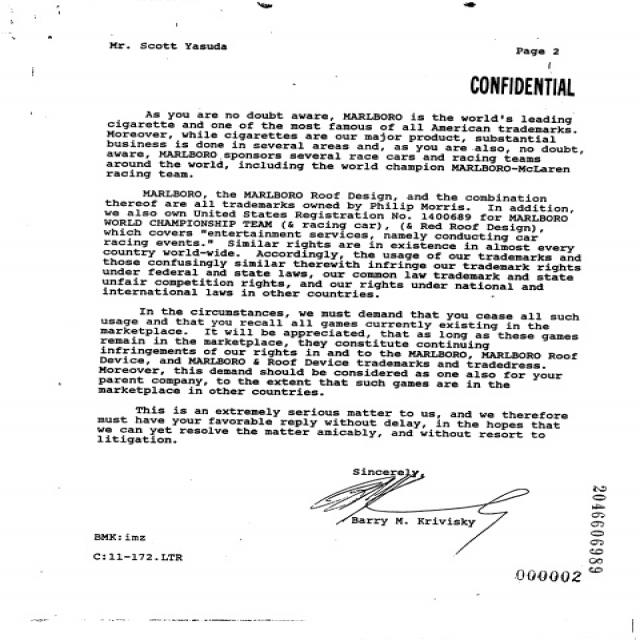

In [2]:
## Let us visualize the data
from google.colab.patches import cv2_imshow
import cv2 as cv
img = cv.imread('/content/drive/MyDrive/MMdetection/data/coco/test2017/adh36e00-page2_2_jpg.rf.edbfbdbc4bcc0c7514d656a29319c8b4.jpg') 
cv2_imshow(img)



## Modelling

#### I used the MMdetection framework for this task because MMdetection framework has a lot of SOTA models and its code and structure are very flexible to modify. More details can be found at https://github.com/open-mmlab/mmdetection/blob/master/docs/en/2_new_data_model.md

In [ ]:
#!git clone https://github.com/open-mmlab/mmdetection.git "/content/drive/MyDrive/MMdetection"

In [ ]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html


#!rm -rf mmdetection
#!git clone https://github.com/open-mmlab/mmdetection.git "/content/drive/MyDrive/MMdetection"
%cd /content/drive/MyDrive/MMdetection

!pip install -e .

from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import copy
import os.path as osp

import mmcv
import numpy as np

from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, init_detector, inference_detector
import torch 



In [ ]:
# Download the pre-trained model checkpoints for inference and finetuning.
os.chdir("/content/drive/MyDrive/MMdetection")
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth\
      -O checkpoints/mask_rcnn_r50_caffe_fpn_mstrain-poly_3x_coco_bbox_mAP-0.408__segm_mAP-0.37_20200504_163245-42aa3d00.pth



In [ ]:
from mmcv.runner import load_checkpoint

from mmdet.apis import inference_detector, show_result_pyplot
from mmdet.models import build_detector

import copy
import os.path as osp

import mmcv
import numpy as np

from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector, init_detector, inference_detector
import torch 

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Modify the config file

#### I used the well known Faster R-CNN algo for this task. Later, I will try YOLO based method.

We need to make sure the class names are the same in train,test, val datasets.

change lr in /content/drive/MyDrive/MMdetection/configs/_base_/schedules

change num_classes in configs/_base_/models/faster_rcnn_r50_fpn.py 

change coco class name in /content/drive/MyDrive/MMdetection/mmdet/core/evaluation/class_names.py

change classes in /content/drive/MyDrive/MMdetection/mmdet/datasets/coco.py 

Overall, we need to change data dir and class name

Since the dataset only has around 1k images, for deep learning model, it is very small. So we need to pay attention to the potential overfitting.

In [ ]:
## start training
!python /content/drive/MyDrive/MMdetection/tools/train.py /content/drive/MyDrive/MMdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/content/drive/MyDrive/MMdetection/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/content/drive/MyDrive/MMdetection/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application 

## Result analysis, error analysis

In [ ]:
import os
os.chdir("/content/drive/MyDrive/MMdetection/")
!python /content/drive/MyDrive/MMdetection/tools/analysis_tools/analyze_logs.py plot_curve /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/20230105_053939.log.json --keys loss_cls loss_bbox --legend loss_cls loss_bbox --out "/content/drive/MyDrive/MMdetection/work_dirs/loss.png"



plot curve of /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/20230105_053939.log.json, metric is loss_cls
plot curve of /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/20230105_053939.log.json, metric is loss_bbox
save curve to: /content/drive/MyDrive/MMdetection/work_dirs/loss.png


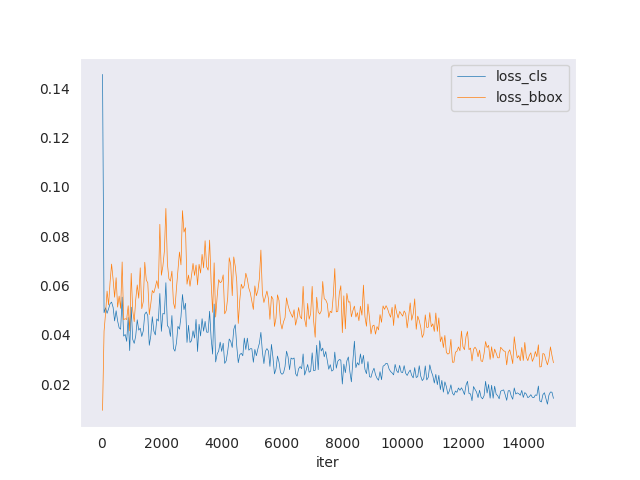

In [ ]:
from google.colab.patches import cv2_imshow
import cv2 as cv
img = cv.imread('/content/drive/MyDrive/MMdetection/work_dirs/loss.png') 
cv2_imshow(img)

In [ ]:
!python /content/drive/MyDrive/MMdetection/tools/analysis_tools/analyze_logs.py plot_curve /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/20230105_053939.log.json --keys acc --legend acc --out "/content/drive/MyDrive/MMdetection/work_dirs/acc.png"

plot curve of /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/20230105_053939.log.json, metric is acc
save curve to: /content/drive/MyDrive/MMdetection/work_dirs/acc.png


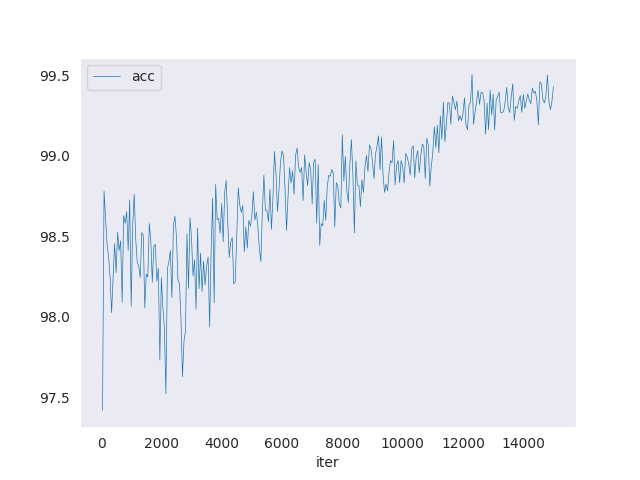

In [ ]:
img = cv.imread('/content/drive/MyDrive/MMdetection/work_dirs/acc.png') 
cv2_imshow(img)

## Inference


In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
import mmcv

In [ ]:
!python /content/drive/MyDrive/MMdetection/tools/test.py /content/drive/MyDrive/MMdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/latest.pth --format-only


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/content/drive/MyDrive/MMdetection/mmdet/utils/setup_env.py:38: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application as needed.
  warnings.warn(
/content/drive/MyDrive/MMdetection/mmdet/utils/setup_env.py:48: UserWarning: Setting MKL_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal performance in your application 

load checkpoint from local path: /content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/latest.pth


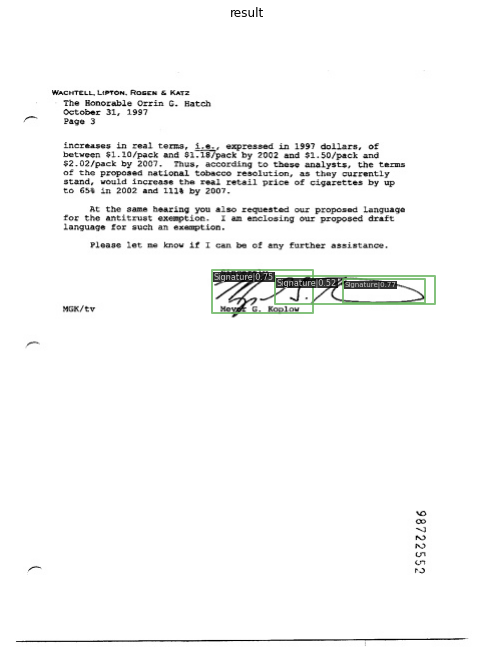

In [ ]:
config_file = '/content/drive/MyDrive/MMdetection/configs/faster_rcnn/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco.py'
checkpoint_file = '/content/drive/MyDrive/MMdetection/work_dirs/faster_rcnn_r50_caffe_fpn_mstrain_3x_coco/latest.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

img = '/content/drive/MyDrive/tobacco800/yolo_format/tobacco_yolo_format/images/train/fys53c00-page02_3.jpg'  # or img = mmcv.imread(img), which will only load it once
result = inference_detector(model, img)

result
# visualize the results in a new window
model.show_result(img, result)
# or save the visualization results to image files
model.show_result(img, result, out_file='/content/drive/MyDrive/MMdetection/Output/result.jpg')

# show the results
show_result_pyplot(model, img, result)




In [ ]:
## the result contains coordinates of the bounding boxes, we can crop it out using simple OpenCV method.
result

[array([[3.3493158e+02, 2.0826860e+02, 4.1637756e+02, 2.3094261e+02,
         8.0190450e-02]], dtype=float32)]

## Practical consideration

Detection model's accuracy is critical, but there are some other practical difficulties when implementing this use case in my actual work experience. For example:

1. background noise. Name was signed on top of stamp, printed text.
2. overlapping of two signatures.
3. misclassify other handwritten text as signature.

Stay tuned and I will share some ways to tackle the above problems.
